In [23]:
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Loading the dataset
df = pd.read_csv('./data/reviews_clean.csv')

In [3]:
# Mapping ratings to values in range 0 - 4 for a one-hot encoding needs
df.Rating = df.Rating.apply(lambda row : row - 1)

In [4]:
# Displaying unique values for ratings
df.Rating.unique()

array([3, 1, 2, 4, 0], dtype=int64)

In [5]:
# Splitting the dataset into train, test and valuation sets
fractions = np.array([0.6, 0.2, 0.2])
df = df.sample(frac=1)
train, val, test = np.array_split(df, (fractions[:-1].cumsum() * len(df)).astype(int))

In [6]:
# Separation of X and targets from aforementioned sets
X_train, y_train = train.Review, train.Rating
X_val, y_val = val.Review, val.Rating
X_test, y_test = test.Review, test.Rating

In [7]:
# Applying a one-hot encoding on targets
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [8]:
# Choosing a BERT model
bert_model_map = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
bert_preprocess_map = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [9]:
# Building a BERT model function
def build_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    preprocessing_layer = hub.KerasLayer(bert_preprocess_map)
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(bert_model_map, trainable=True)
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(5, activation=None)(net)

    return tf.keras.Model(text_input, net)

In [10]:
# Setting parameters
epochs = 5
batch_size = 32

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

steps_per_epoch = len(X_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [11]:
# Model compiling
bert_model = build_model()
bert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [12]:
# Model Learning
bert_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size )

Epoch 1/5
385/385 [==============================] - 139s 345ms/step - loss: 1.5021 - categorical_accuracy: 0.4004 - val_loss: 1.2343 - val_categorical_accuracy: 0.4688
Epoch 2/5
385/385 [==============================] - 134s 349ms/step - loss: 1.1686 - categorical_accuracy: 0.4893 - val_loss: 1.0147 - val_categorical_accuracy: 0.5610
Epoch 3/5
385/385 [==============================] - 134s 349ms/step - loss: 0.9830 - categorical_accuracy: 0.5615 - val_loss: 0.8930 - val_categorical_accuracy: 0.6120
Epoch 4/5
385/385 [==============================] - 139s 361ms/step - loss: 0.8905 - categorical_accuracy: 0.6055 - val_loss: 0.8662 - val_categorical_accuracy: 0.6245
Epoch 5/5
385/385 [==============================] - 136s 354ms/step - loss: 0.8355 - categorical_accuracy: 0.6321 - val_loss: 0.8453 - val_categorical_accuracy: 0.6442


In [13]:
# Evaluating a model's performance
bert_model.evaluate(X_test, y_test)

129/129 [==============================] - 22s 166ms/step - loss: 0.8443 - categorical_accuracy: 0.6209


[0.8442505598068237, 0.6208831667900085]

In [20]:
# Predicting values for a test set
y_pred = bert_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

129/129 [==============================] - 21s 162ms/step


In [24]:
# Creating a confusion matrix
y_true = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)

<AxesSubplot: >

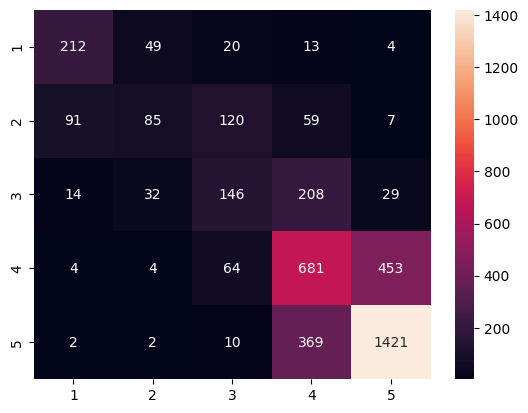

In [22]:
# Displaying a confusion matrix
possible_reviews = range(1,6)
conf_matrix_df = pd.DataFrame(conf_matrix, columns=possible_reviews, index=possible_reviews)

sn.heatmap(conf_matrix_df, annot=True, fmt='g', annot_kws={"size": 10})

In [26]:
# Displaying a classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.71      0.68       298
           1       0.49      0.23      0.32       362
           2       0.41      0.34      0.37       429
           3       0.51      0.56      0.54      1206
           4       0.74      0.79      0.76      1804

    accuracy                           0.62      4099
   macro avg       0.56      0.53      0.53      4099
weighted avg       0.61      0.62      0.61      4099

